In [1]:
import os
import pickle
from natsort import natsorted
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import oapackage as oa
from natsort import natsorted
#import Orange

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib
%matplotlib inline

# Model Selection
## integrate three selection strategies


In [20]:
# functions for DTO
def l2norm(matrix_1, matrix_2):
    """calculate Euclidean distance
    Args:
        matrix_1 (n*d np array): n is the number of instances, d is num of metric
        matrix_2 (n*d np array): same as matrix_1
    Returns:
        float: the row-wise Euclidean distance 
    """
    return np.power(np.sum(np.power(matrix_1-matrix_2, 2), axis=1), 0.5)
    

def DTO(performacne_metric):
    """calculate DTO for each condidate model
    Args:
        performacne_metric (array): 2D array, row: models, column: AUC of different subgroups
    """

    normalized_metric = np.zeros(performacne_metric.shape)
    utopias = []
    for i in range(performacne_metric.shape[1]):
        utopias.append(np.max(performacne_metric[:, i]))
        normalized_metric[:, i] = performacne_metric[:, i] / np.max(performacne_metric[:, i])
    
    # Calculate Euclidean distance
    distances = l2norm(normalized_metric, np.ones_like(normalized_metric))
    
    # return the index of model with the smallest distance
    return np.argmin(distances)

In [21]:
# Functions for Pareto

def find_mingroup(df):
    aucs = df[list(df.filter(regex=("auc-group")))]
    aucs = aucs.to_numpy()
    maxs = []
    for i in range(aucs.shape[1]):
        temp = aucs[:, i].tolist()
        maxs.append(max(temp))
    min_idx = np.argmin(maxs)
    return min_idx
    

def get_groups(df, metric = 'auc'):
    aucs = df[natsorted(list(df.filter(regex=(metric+'-group'))))].values.T
    groups = []
    for i in range((aucs.shape[0])):
        groups.append(aucs[i, :].astype('float'))
    return groups

def cal_pareto(groups, min_group_no):
    pareto=oa.ParetoDoubleLong()
    for i in range(groups[0].shape[0]):
        w= oa.doubleVector(tuple([group[i] for group in groups]))
        pareto.addvalue(w, i)
    datapoints = np.stack(groups)
    lst=pareto.allindices()
    optimal_datapoints=datapoints[:,lst]

    loc = np.argmax(optimal_datapoints.T[:, min_group_no])
    #loc = np.argmax(optimal_datapoints.T[:, 1])
    return lst[loc]


In [22]:
# config

# exp_dict = {'HAM10000': [{'attribute': 'Sex', 'sens_num': 2}], 'HAM100004': [{'attribute': 'Age', 'sens_num': 4}], 
#            'CXP': [{'attribute': 'Age', 'sens_num': 5}, {'attribute': 'Sex', 'sens_num': 2}, {'attribute': 'Race', 'sens_num': 2}],
#            'MIMIC_CXR': [{'attribute': 'Age', 'sens_num': 5}, {'attribute': 'Sex', 'sens_num': 2}, {'attribute': 'Race', 'sens_num': 2}],
#            'PAPILA': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
#            'ADNI': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
#            'OCT': [{'attribute': 'Age', 'sens_num': 2}],
#            'COVID_CT_MD': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
#            'Fitz17k': [{'attribute': 'skin_type', 'sens_num': 6}],}

exp_dict = {'MIMIC_CXR':[{'attribute': 'Age', 'sens_num': 5},{'attribute':'Sex','sens_num':2},{'attribute':'Race','sens_num':2}]}

model_selections = ['overall_auc']
#, 'DTO']
#model_selections = ['overall_auc', 'pareto', 'DTO']

methods = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD','DomainInd']
#methods = ['baseline', 'resampling', 'DomainInd', 'LAFTR', 'CFair','LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']

path = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/your_path/fariness_data/model_records/'

In [23]:
results = pd.DataFrame()

# should probably figure out a more sustainable way to write this code so that if some data is missing it still runs!!

for model_selection in model_selections:
    for key, sens_exps in exp_dict.items():
        dataset = key
        for sens_exp in sens_exps:
            methods = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD','DomainInd']

            attribute = sens_exp['attribute']
            sens_num = sens_exp['sens_num']
            if dataset in ['OCT', 'ADNI', 'COVID_CT_MD']:
                backbone = 'cusResNet18_3d'
            elif dataset in ['RadFusion_EHR']:
                backbone = 'cusMLP'
            else:
                backbone = 'cusResNet18'
            
            means, stds, hashs = [], [], []
            #index = []
            mean_metrics = pd.DataFrame()
            std_metrics = pd.DataFrame()

            for method in methods:
                val_stats = natsorted(glob.glob(path + '/{datas}/{attr}/{bkb}/{meth}/*_val_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone, meth = method)))
                
                test_stats = natsorted(glob.glob(path + '/{datas}/{attr}/{bkb}/{meth}/*_test_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone, meth = method)))
                
                val_metrics = pd.DataFrame()
                
                for val_stat in val_stats:
                    hash_id = val_stat.split('/')[-1].split('_')[1]
                    val_stat_df = pd.read_csv(val_stat)
                    val_stat_df['hash'] = hash_id
                    val_metrics = pd.concat([val_metrics, pd.DataFrame(val_stat_df.iloc[0]).T], ignore_index=True)
                
                # decide min/max AUC group before selection
                if method == 'baseline':
                    min_group_no = find_mingroup(val_metrics)

                # model selection --> find hash id
                if model_selection == 'overall_auc':
                    hash_id = val_metrics.iloc[pd.to_numeric(val_metrics['Val Overall AUC']).idxmax()]['hash']
                elif model_selection == 'DTO':
                    aucs = val_metrics[list(val_metrics.filter(regex=("auc-group")))].values
                    model_idx = DTO(aucs)
                    hash_id = val_metrics.iloc[model_idx]['hash']
                elif model_selection == 'pareto':
                    groups = get_groups(val_metrics, 'auc')
                    lst_loc = cal_pareto(groups, min_group_no)
                    hash_id = val_metrics.iloc[lst_loc]['hash']
                else:
                    raise ValueError("selection strategy not supported")
                    
                hashs.append(hash_id)
                test_result = pd.read_csv(path + '/{datas}/{attr}/{bkb}/{meth}/{meth}_{hashid}_test_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone,meth = method, hashid = hash_id))
                
                mean_metrics = pd.concat([mean_metrics, pd.DataFrame(test_result.iloc[0]).T])
                std_metrics = pd.concat([std_metrics, pd.DataFrame(test_result.iloc[1]).T])
  
        
            try:
                mean_metrics = mean_metrics.drop(columns = ['Unnamed: 0'])
                std_metrics = std_metrics.drop(columns = ['Unnamed: 0'])
            except:
                pass

            mean_metrics = mean_metrics.astype('float').round(4)
            std_metrics = std_metrics.astype('float').round(3)

            mean_metrics = mean_metrics.add_prefix('mean ')
            std_metrics = std_metrics.add_prefix('std ')

            out = pd.concat([mean_metrics.reset_index(drop=True), std_metrics.reset_index(drop=True)], axis=1)
                
            # out = pd.concat([mean_metrics.reset_index(drop=True).stack(), std_metrics.reset_index(drop=True).stack()], axis=1) \
            #         .apply(lambda x: u"\u00B1".join(x.astype('str')), axis=1) \
            #         .unstack()
            # decided this ^ was unnecessary bc just gives the weird plus minus
            
            out['methods'] = methods

            out = out[ ['methods'] + [ col for col in out.columns if col != 'methods' ] ]
            out['hash'] = hashs

            out.to_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/{}/{}-{}.csv'.format(model_selection, dataset, attribute), index = False)


In [2]:
auc_results_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/{}-{}.csv'.format('overall_auc', dataset, attribute))
auc_results_df

NameError: name 'dataset' is not defined

In [ ]:
sex_results_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/overall_auc/MIMIC_CXR-Sex.csv')
age_results_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/overall_auc/MIMIC_CXR-Age.csv')

/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papi

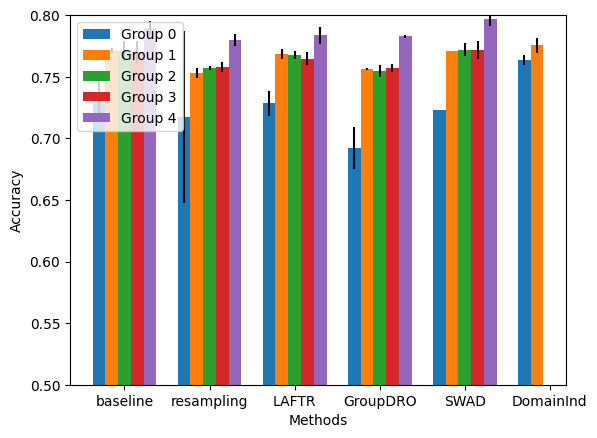

In [ ]:
mean_cols = ['mean Test acc-group_{}'.format(i) for i in range(5)]
sd_cols = ['std Test acc-group_{}'.format(i) for i in range(5)]

# Convert the columns to numeric
numeric_cols = mean_cols + sd_cols
age_results_df[numeric_cols] = age_results_df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.15  # Adjust as needed

# Set up positions for the bars
bar_positions = [range(len(age_results_df['methods'])) for _ in range(5)]
bar_positions = [[pos + i * bar_width for pos in bar_positions[0]] for i in range(5)]

# Create bar plots with error bars for each group
for i in range(5):
    plt.bar(bar_positions[i], age_results_df[mean_cols[i]], yerr=age_results_df[sd_cols[i]], width=bar_width, label=f'Group {i}')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.ylim((0.5, 0.8))  # Adjust the y-axis limits as needed
plt.xticks([pos + bar_width * 2 for pos in bar_positions[0]], age_results_df['methods'])
plt.legend()

# Show the plot
plt.show()

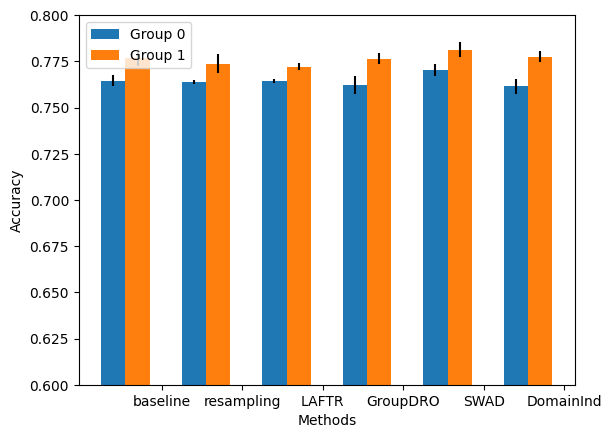

In [ ]:
s = 2 # number of sensitive attributes
df = sex_results_df

mean_cols = ['mean Test acc-group_{}'.format(i) for i in range(s)]
sd_cols = ['std Test acc-group_{}'.format(i) for i in range(s)]

# Convert the columns to numeric
numeric_cols = mean_cols + sd_cols
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.3  # Adjust as needed

# Set up positions for the bars
bar_positions = [range(len(df['methods'])) for _ in range(s)]
bar_positions = [[pos + i * bar_width for pos in bar_positions[0]] for i in range(s)]

# Create bar plots with error bars for each group
for i in range(s):
    plt.bar(bar_positions[i], df[mean_cols[i]], yerr=df[sd_cols[i]], width=bar_width, label=f'Group {i}')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.ylim((0.6, 0.8))  # Adjust the y-axis limits as needed
plt.xticks([pos + bar_width * 2 for pos in bar_positions[0]], df['methods'])
plt.legend()

# Show the plot
plt.show()

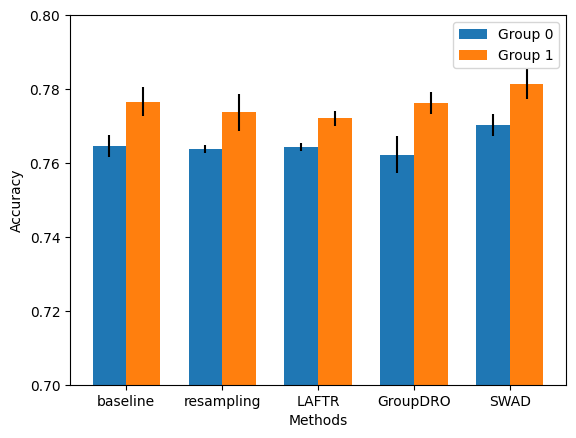

In [ ]:
auc_results_df[['Mean acc-group_0', 'acc-SD-group_0']] = auc_results_df['Test acc-group_0'].str.split('±', expand=True)
auc_results_df[['Mean acc-group_1', 'acc-SD-group_1']] = auc_results_df['Test acc-group_1'].str.split('±', expand=True)

# Convert the columns to numeric
numeric_cols = ['Mean acc-group_0', 'acc-SD-group_0', 'Mean acc-group_1', 'acc-SD-group_1']
auc_results_df[numeric_cols] = auc_results_df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.35

# Set up positions for the bars
bar_positions_group_0 = range(len(auc_results_df['methods']))
bar_positions_group_1 = [pos + bar_width for pos in bar_positions_group_0]

# Create bar plots with error bars
plt.bar(bar_positions_group_0, auc_results_df['Mean acc-group_0'], yerr=auc_results_df['acc-SD-group_0'], width=bar_width, label='Group 0')
plt.bar(bar_positions_group_1, auc_results_df['Mean acc-group_1'], yerr=auc_results_df['acc-SD-group_1'], width=bar_width, label='Group 1')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.ylim((0.7,0.8))
plt.xticks([pos + bar_width/2 for pos in bar_positions_group_0], auc_results_df['methods'])
plt.legend()

# Show the plot
plt.show()

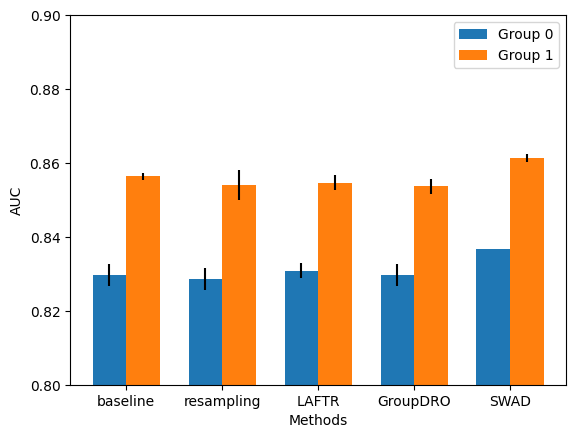

In [ ]:
auc_results_df[['Mean auc-group_0', 'SD-group_0']] = auc_results_df['Test auc-group_0'].str.split('±', expand=True)
auc_results_df[['Mean auc-group_1', 'SD-group_1']] = auc_results_df['Test auc-group_1'].str.split('±', expand=True)

# Convert the columns to numeric
numeric_cols = ['Mean auc-group_0', 'SD-group_0', 'Mean auc-group_1', 'SD-group_1']
auc_results_df[numeric_cols] = auc_results_df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.35

# Set up positions for the bars
bar_positions_group_0 = range(len(auc_results_df['methods']))
bar_positions_group_1 = [pos + bar_width for pos in bar_positions_group_0]

# Create bar plots with error bars
plt.bar(bar_positions_group_0, auc_results_df['Mean auc-group_0'], yerr=auc_results_df['SD-group_0'], width=bar_width, label='Group 0')
plt.bar(bar_positions_group_1, auc_results_df['Mean auc-group_1'], yerr=auc_results_df['SD-group_1'], width=bar_width, label='Group 1')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('AUC')
plt.ylim((0.8,0.9))
plt.xticks([pos + bar_width/2 for pos in bar_positions_group_0], auc_results_df['methods'])
plt.legend()

# Show the plot
plt.show()

### Calculate Max/Min/Gap for Different selections


In [ ]:
def get_max_min_gap(df_ori):
    df = df_ori.copy()
    mean_std = df.drop(columns=['hash']).to_numpy()

    rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
    means = np.zeros(rt.shape)
    
    for i in range(rt.shape[0]):
        for j in range(rt.shape[1]):
            means[i][j] = float(rt[i][j][0])
    means = pd.DataFrame(means, columns = df.columns[1:-1])

    aucs = means[list(means.filter(regex=("auc-group")))]
    aucs = aucs.to_numpy()
    max_auc, min_auc = [], []
    for i in range(aucs.shape[0]):
        temp = aucs[i].tolist()
        max_auc.append(max(temp))
        min_auc.append(min(temp))
    gap = np.asarray(max_auc)-np.asarray(min_auc)
    return np.asarray(max_auc), np.asarray(min_auc), gap

ROOT = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/'
test_results_path = os.path.join(ROOT,'results/selections/')
selections = ['DTO', 'overall_auc'] # 'pareto']
for selection in selections:
    exp_paths = os.listdir(os.path.join(test_results_path, selection))
    for exp_path in exp_paths:
        
        result_path = os.path.join(test_results_path, selection, exp_path)
        results = pd.read_csv(result_path)
        # cal
        max_auc, min_auc, gap = get_max_min_gap(results)
        results['Max AUC'] = max_auc
        results['Min AUC'] = min_auc
        results['AUC Gap'] = gap
    
        results.to_csv(result_path, index = False)

### Calculate EqOdd for non-binary subgroups for completeness

## rank them

In [ ]:
#methods = ['baseline', 'resampling', 'DomainInd', 'LAFTR', 'CFair', 'LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']
methods = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD']

for selection in selections:
    result_path = os.path.join(ROOT,'results/selections/{}/'.format(selection))
    results = glob.glob(result_path + '*.csv')

    for result in results:
        names = result.split('/')[-1].split('.csv')[0].split('-')
        dataset, sensitive  = names[0], names[1]
        #if dataset != 'RadFusion_EHR':
        #    continue
        
        mean_std_df = pd.read_csv(result).drop(columns=['hash'])
        
        mean_std = mean_std_df.to_numpy()
        
        rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
        means = np.zeros(rt.shape)
        
        for i in range(rt.shape[0]):
            for j in range(rt.shape[1]):
                means[i][j] = float(rt[i][j][0])
        means = pd.DataFrame(means, columns = mean_std_df.columns[1:])
        # todo some ascending, some descending
        means = means.rank(ascending = False, numeric_only = True)
        try:
            means['methods'] = methods
        except:
            means['methods'] = mean_std_df['methods']
        means = means[ ['methods'] + [ col for col in means.columns if col != 'methods' ] ]
    
        means.to_csv(os.path.join(ROOT,'results/selections/{}/{}-{}.csv'.format(selection+'_rank', dataset, sensitive)), index = False)
means

,methods,Test Overall AUC,Test auc-group_0,Test auc-group_1,Test Overall Acc,Test acc-group_0,Test acc-group_1,Test DP,Test EqOpp1,Test EqOpp0,...,Test worst_auc,Test Overall FPR,Test Overall FNR,Test FPR-group_0,Test FPR-group_1,Test FNR-group_0,Test FNR-group_1,Max AUC,Min AUC,AUC Gap
0,baseline,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,...,3.0,4.0,1.5,4.0,3.0,2.0,2.0,2.0,3.0,1.0
1,resampling,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,2.0,3.0,2.0,2.0,1.0,4.0,4.0,5.0,2.0
2,LAFTR,3.0,2.0,3.0,5.0,3.0,5.0,5.0,5.0,5.0,...,2.0,1.0,4.0,3.0,1.0,3.0,5.0,3.0,2.0,5.0
3,GroupDRO,4.0,4.0,5.0,3.0,5.0,3.0,1.0,3.0,2.0,...,4.0,3.0,1.5,1.0,4.0,4.0,1.0,5.0,4.0,4.0
4,SWAD,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,5.0,5.0,5.0,5.0,5.0,3.0,1.0,1.0,3.0


## Statistic Test

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp
import glob
import Orange
import matplotlib.pyplot as plt
import seaborn as sns

ImportError: cannot import name '_variable' from partially initialized module 'Orange.data' (most likely due to a circular import) (/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/Orange/data/__init__.py)

In [ ]:
selections = ['overall_auc', 'DTO']
Metrics = ['Min AUC', 'AUC Gap', 'Test Overall AUC']
#methods_toplot = ['ERM', 'Resampling', 'DomainInd', 'LAFTR', 'CFair', 'LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']
methods_toplot = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD']


for metric in Metrics:
    for selection in selections:
        result_path = os.path.join(ROOT,'results/selections/{}/'.format(selection + '_rank'))
        
        results = glob.glob(result_path + '*.csv')
    
        min_ranks, max_ranks, gap_ranks, overall_ranks = [], [], [], []
        ranks = []
        for result in results:
            names = result.split('/')[-1].split('.csv')[0].split('-')
            dataset, sensitive  = names[0], names[1]
            if dataset not in exp_dict.keys():
                continue
            
            mean_std_df = pd.read_csv(result)
            
            values = mean_std_df[metric].values
            if metric == 'AUC Gap':
                values = 12 - values
            ranks.append(values)
    
            avgrank = np.nanmean(ranks, 0)
            
        cd = Orange.evaluation.compute_CD(avgrank, len(ranks), alpha='0.05', test='nemenyi') 
        print('cd=', cd)
        Orange.evaluation.graph_ranks(avgrank, methods_toplot, cd=cd, width=5, textspace=1.5,
                                filename = 'results/selections/cd_diagrams/{}_{}_in_distribution.pdf'.format(selection, metric))

    

### Results of Baseline under different model selections

### rank across datasets

In [ ]:
selections = ['overall_auc', 'DTO', 'pareto']
#Metrics = ['Max AUC', 'Min AUC', 'AUC Gap', 'Test Overall AUC']
Metrics = ['Test Overall AUC']

methods_toplot = ['ERM']
total_df = pd.DataFrame()

for selection in selections:
    
    value_path = './results/selections/{}/'.format(selection)
    value_results = natsorted(glob.glob(value_path + '*.csv'))

    mean_values = []
    column_names = []
    for value_result in value_results:
        dataset, sensitive = value_result.split('/')[-1].split('.csv')[0].split('-')
        column_names.append(dataset  + '-' + sensitive)

        # process values
        value_df = pd.read_csv(value_result).drop(columns=['hash'])
        mean_std = value_df.to_numpy()
        
        rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
        means = np.zeros(rt.shape)
        
        for i in range(rt.shape[0]):
            for j in range(rt.shape[1]):
                means[i][j] = float(rt[i][j][0])
        means = pd.DataFrame(means, columns = value_df.columns[1:])

        values = means[Metrics].iloc[0]
        mean_values.append(values)

    mean_values = np.stack(mean_values).squeeze()
        
    total_df = pd.concat([total_df, pd.DataFrame([mean_values], columns=column_names)])

total_df['Selection Strategy'] = ['Overall Performance', 'DTO', 'Pareto Optimal']
total_df = total_df[ ['Selection Strategy'] + [ col for col in total_df.columns if col != 'Selection Strategy' ] ]
total_df

total_rank_df = total_df.rank(ascending = False, numeric_only = True)
rank_values = total_rank_df.to_numpy()
avgrank = np.mean(rank_values, axis=1)

cd = Orange.evaluation.compute_CD(avgrank, 16, alpha='0.05', test='nemenyi') #tested on 13 datasets 
print('cd=', cd)
Orange.evaluation.graph_ranks(avgrank, total_df['Selection Strategy'].values, cd=cd, width=5, textspace=1.5,
                        filename = 'results/selections/cd_diagrams/{}_{}_in_distribution.pdf'.format(selection, metric))
           

## Plot for ”Bias widely exists“

In [ ]:
selections = ['overall_auc']
#Metrics = ['Max AUC', 'Min AUC', 'AUC Gap', 'Test Overall AUC']
Metrics = ['AUC Gap']

def get_aucs(dataset, sensitive, mode = 'id'):
    
    filename = dataset + '-' + sensitive + '.csv'
    result_path = './results/selections/overall_auc/'
    mean_std_df = pd.read_csv(result_path + filename).drop(columns=['hash'])
    
    mean_std = mean_std_df.to_numpy()

    rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
    means = np.zeros(rt.shape)
    
    for i in range(rt.shape[0]):
        for j in range(rt.shape[1]):
            means[i][j] = float(rt[i][j][0])
            #stds[i][j] = float(rt[i][j][1])
    means = pd.DataFrame(means, columns = mean_std_df.columns[1:])

    aucs = means[list(means.filter(regex=("auc-group")))].iloc[0].values.tolist()
    max_auc, min_auc = np.max(aucs), np.min(aucs)

    if dataset in ['MIMIC_CXR', 'CXP']:
        fprs = means[list(means.filter(regex=("FPR-group")))].iloc[0].values.tolist()
        max_under, min_under = np.max(fprs), np.min(fprs)
    else:
        fnrs = means[list(means.filter(regex=("FNR-group")))].iloc[0].values.tolist()
        max_under, min_under = np.max(fnrs), np.min(fnrs)


    return max_auc, min_auc, max_under, min_under #np.asarray(max_auc), , harmonic_mean


total_df = pd.DataFrame()
for selection in selections:
    
    value_path = './results/selections/{}/'.format(selection)
    value_results = natsorted(glob.glob(value_path + '*.csv'))

    maxs, mins, max_unders, min_unders, names = [], [], [], [], []
    for value_result in value_results:
        dataset, sensitive = value_result.split('/')[-1].split('.csv')[0].split('-')
        
        max_auc, min_auc, max_under, min_under = get_aucs(dataset, sensitive)
        
        maxs.append(max_auc)
        mins.append(min_auc)
        max_unders.append(max_under)
        min_unders.append(min_under)
        names.append(dataset+'-'+sensitive)


In [ ]:
names = ['ADNI-Age', 'ADNI-Sex', 'COVID_CT_MD-Age', 'COVID_CT_MD-Sex', 'CheXpert-Age', 'CheXpert-Sex', 'CheXpert-Race', 
'Fitzpatrick17k-skin_type', 'HAM10000-Sex', 'HAM10000-Age', 'MIMIC_CXR-Age', 'MIMIC_CXR-Race', 
'MIMIC_CXR-Sex', 'OCT-Age', 'PAPILA-Age', 'PAPILA-Sex']

In [ ]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

<AxesSubplot:xlabel='Min Underdiagnosis Rate', ylabel='Max Underdiagnosis Rate'>

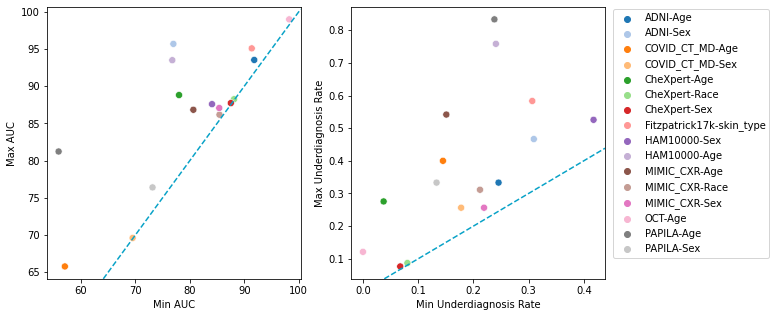

In [ ]:
df = pd.DataFrame([names, maxs, mins], index = ['Datasets', 'Max AUC', 'Min AUC']).T
df2 = pd.DataFrame([names, max_unders, min_unders], index = ['Datasets', 'Max Underdiagnosis Rate', 'Min Underdiagnosis Rate']).T
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
sns.scatterplot(data = df, x = 'Min AUC', y = 'Max AUC', hue = 'Datasets', s = 50, palette = 'tab20', ax = ax)
#ax.legend(bbox_to_anchor=(1.01, 1.05))
ax.get_legend().remove()
add_identity(ax, color="#08a2c7", ls='--')

ax2 = fig.add_subplot(122)
sns.scatterplot(data = df2, x = 'Min Underdiagnosis Rate', y = 'Max Underdiagnosis Rate', hue = 'Datasets', s = 50, palette = 'tab20', ax = ax2)
ax2.legend(bbox_to_anchor=(1.01, 1.01))
add_identity(ax2, color="#08a2c7", ls='--')
plt.savefig('./results/plots/bias_exists.png', dpi = 400, bbox_inches = 'tight')

## My analysis on ERM model

In [3]:
val_stat_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/your_path/fariness_data/model_records/MIMIC_CXR/Race/cusResNet18/baseline/baseline_e0abf1f056_val_pred_stat.csv')
val_stat_df

,Unnamed: 0,Val Overall AUC,Val auc-group_0,Val auc-group_1,Val Overall Acc,Val acc-group_0,Val acc-group_1,Val DP,Val EqOpp1,Val EqOpp0,...,Val specificity_at_thres-group_1,Val ECE-group_1,Val BCE-group_1,Val worst_auc,Val Overall FPR,Val Overall FNR,Val FPR-group_0,Val FPR-group_1,Val FNR-group_0,Val FNR-group_1
0,mean,0.851019,0.848599,0.849715,0.776613,0.781382,0.765371,0.871575,0.925915,0.932308,...,0.810849,0.017352,0.477773,0.848599,0.228336,0.214548,0.208767,0.282867,0.238767,0.171100
1,std,0.001270,0.001469,0.001067,0.002021,0.001916,0.002294,0.001803,0.002412,0.002274,...,0.015085,0.005744,0.001706,0.001469,0.005984,0.005057,0.005616,0.007253,0.005605,0.004272
2,ci95_hi,0.852457,0.850262,0.850923,0.778900,0.783550,0.767967,0.873615,0.928644,0.934882,...,0.827919,0.023852,0.479703,0.850262,0.235107,0.220271,0.215122,0.291074,0.245109,0.175934
3,ci95_lo,0.849582,0.846936,0.848508,0.774326,0.779214,0.762776,0.869534,0.923185,0.929734,...,0.793779,0.010852,0.475843,0.846936,0.221564,0.208825,0.202411,0.274659,0.232424,0.166266


In [4]:
val_stat_df.columns

Index(['Unnamed: 0', 'Val Overall AUC', 'Val auc-group_0', 'Val auc-group_1',
       'Val Overall Acc', 'Val acc-group_0', 'Val acc-group_1', 'Val DP',
       'Val EqOpp1', 'Val EqOpp0', 'Val EqOdd', 'Val EqOdd_0.5',
       'Val EqOdd_specificity_0.8', 'Val EqOdd_sensitivity_0.8',
       'Val Overall ECE', 'Val Overall BCE', 'Val tpr_at_tnr_0',
       'Val fnr_at_thres-group_0', 'Val fpr_at_thres-group_0',
       'Val recall_at_thres-group_0', 'Val specificity_at_thres-group_0',
       'Val ECE-group_0', 'Val BCE-group_0', 'Val tpr_at_tnr_1',
       'Val fnr_at_thres-group_1', 'Val fpr_at_thres-group_1',
       'Val recall_at_thres-group_1', 'Val specificity_at_thres-group_1',
       'Val ECE-group_1', 'Val BCE-group_1', 'Val worst_auc',
       'Val Overall FPR', 'Val Overall FNR', 'Val FPR-group_0',
       'Val FPR-group_1', 'Val FNR-group_0', 'Val FNR-group_1'],
      dtype='object')

In [3]:
pred_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/your_path/fariness_data/model_records/MIMIC_CXR/Sex/cusResNet18/baseline/pred.csv')
pred_df = pred_df.set_index('index')
pred_df                        

,pred,label
index,,
19405,1.0,1.0
5222,0.0,0.0
17280,0.0,0.0
27253,0.0,0.0
23656,0.0,0.0
...,...,...
18932,0.0,0.0
8913,1.0,0.0
7111,0.0,0.0


In [4]:
test_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/data/mimic-cxr/splits/test.csv')
test_df['binary_label'] = np.float64(test_df['No Finding'].astype(float) > 0)
test_df

,Unnamed: 0,path,patient_cat,subject_id,study_id,image,patient_study_id,Race_multi,Sex,anchor_age,...,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,binary_label
0,0,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16187827,56495550,a4881c3f-2cbb518b-5ae285c0-2eb7dce3-8581dd5a.jpg,p16187827s56495550,WHITE,M,80,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
1,1,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16187827,56495550,ef942ffb-b4ae474f-78a10926-7968938b-a27467d6.jpg,p16187827s56495550,WHITE,M,80,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
2,2,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16160632,59201056,694ce382-1f0b42e0-eaf0e2cb-b7bf3429-2b7582f6.jpg,p16160632s59201056,WHITE,F,54,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
3,3,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16160632,59201056,048ee716-f88d3a1d-4e18e4c3-c02b1bc8-37fe382e.jpg,p16160632s59201056,WHITE,F,54,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
4,4,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16832247,56990152,1d581b80-72540fcc-73e8a190-11bfb345-0d9a5573.jpg,p16832247s56990152,WHITE,M,55,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30311,30311,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,50750534,e950eaec-86cdecda-4e76cc0b-16f559cd-61e65491.jpg,p15209552s50750534,WHITE - OTHER EUROPEAN,M,62,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,1.0,0.0
30312,30312,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,57762126,42b3fab4-1969d82b-944595a3-2bea4279-49a807f7.jpg,p15209552s57762126,WHITE - OTHER EUROPEAN,M,62,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,0.0,1.0,0.0
30313,30313,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,56080237,b6c841d5-18a44354-d9033bda-59b522f2-5e0676bc.jpg,p15209552s56080237,WHITE - OTHER EUROPEAN,M,62,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0
30314,30314,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,58337039,4c7cc152-1d72f639-17a59190-cc6060f1-06d22c91.jpg,p15209552s58337039,WHITE - OTHER EUROPEAN,M,62,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0


In [5]:
metadata_path = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/physionet.org/files/mimiciv/2.2/hosp/'
admissions_file = 'admissions.csv.gz'

admissions_df = pd.read_csv(os.path.join(metadata_path,admissions_file))
admissions_df_no_duplicates = admissions_df.drop_duplicates(subset='subject_id')
admissions_df_no_duplicates = admissions_df_no_duplicates[['subject_id','hadm_id','insurance','language','marital_status','race']] # keep only relevant columns
test_df= pd.merge(test_df,admissions_df_no_duplicates[['subject_id','insurance', 'marital_status']], on='subject_id',how='left')
test_df

,Unnamed: 0,path,patient_cat,subject_id,study_id,image,patient_study_id,Race_multi,Sex,anchor_age,...,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,binary_label,insurance,marital_status
0,0,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16187827,56495550,a4881c3f-2cbb518b-5ae285c0-2eb7dce3-8581dd5a.jpg,p16187827s56495550,WHITE,M,80,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,Medicare,MARRIED
1,1,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16187827,56495550,ef942ffb-b4ae474f-78a10926-7968938b-a27467d6.jpg,p16187827s56495550,WHITE,M,80,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,Medicare,MARRIED
2,2,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16160632,59201056,694ce382-1f0b42e0-eaf0e2cb-b7bf3429-2b7582f6.jpg,p16160632s59201056,WHITE,F,54,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,Medicare,SINGLE
3,3,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16160632,59201056,048ee716-f88d3a1d-4e18e4c3-c02b1bc8-37fe382e.jpg,p16160632s59201056,WHITE,F,54,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,Medicare,SINGLE
4,4,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16832247,56990152,1d581b80-72540fcc-73e8a190-11bfb345-0d9a5573.jpg,p16832247s56990152,WHITE,M,55,...,1.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,Other,DIVORCED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30311,30311,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,50750534,e950eaec-86cdecda-4e76cc0b-16f559cd-61e65491.jpg,p15209552s50750534,WHITE - OTHER EUROPEAN,M,62,...,NaN,NaN,1.0,NaN,NaN,0.0,1.0,0.0,Other,SINGLE
30312,30312,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,57762126,42b3fab4-1969d82b-944595a3-2bea4279-49a807f7.jpg,p15209552s57762126,WHITE - OTHER EUROPEAN,M,62,...,1.0,NaN,1.0,NaN,NaN,0.0,1.0,0.0,Other,SINGLE
30313,30313,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,56080237,b6c841d5-18a44354-d9033bda-59b522f2-5e0676bc.jpg,p15209552s56080237,WHITE - OTHER EUROPEAN,M,62,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,Other,SINGLE
30314,30314,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15209552,58337039,4c7cc152-1d72f639-17a59190-cc6060f1-06d22c91.jpg,p15209552s58337039,WHITE - OTHER EUROPEAN,M,62,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,Other,SINGLE


In [6]:
# check that indexes in both dfs correspond to same image
true_df = pd.DataFrame(test_df['binary_label'].sort_index() == pred_df['label'].sort_index())
true_df.value_counts()

True    30316
dtype: int64

In [7]:
test_df['erm_pred'] = pred_df['pred']

# inverted these because 0 is disease and 1 is no disease (negatiev)
test_df['FN'] = np.where((test_df['binary_label']==0) & (test_df['erm_pred']==1),1,0)
test_df['FP'] = np.where((test_df['binary_label']==1) & (test_df['erm_pred']==0),1,0)
test_df['TN'] = np.where((test_df['binary_label']==1) & (test_df['erm_pred']==1),1,0)
test_df['TP'] = np.where((test_df['binary_label']==0) & (test_df['erm_pred']==0),1,0)

In [8]:
test_df.columns

Index(['Unnamed: 0', 'path', 'patient_cat', 'subject_id', 'study_id', 'image',
       'patient_study_id', 'Race_multi', 'Sex', 'anchor_age', 'Race',
       'Age_multi', 'Age_binary', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'binary_label', 'insurance', 'marital_status', 'erm_pred', 'FN', 'FP',
       'TN', 'TP'],
      dtype='object')

In [9]:
# add procedure information
ROOT_FOLDER = '/gpfs3/well/papiez/shared/mimic-cxr-jpg/physionet.org/files/mimic-cxr-jpg/2.0.0'
metadata_path = os.path.join(ROOT_FOLDER, 'mimic-cxr-2.0.0-metadata.csv.gz')
metadata_df = pd.read_csv(metadata_path)
test_df= pd.merge(test_df,metadata_df[['subject_id','PerformedProcedureStepDescription']], on='subject_id',how='left')

# ANALYSE POSSIBLE BIASES IN ERM MODEL

In [ ]:
def filter_groups(group,min_size):
    return len(group) > min_size

def visualise_results(test_df,attribute,col_name,filter_group_size=True,min_size = 300):
    df = test_df
    grouped_df = df.groupby(col_name)

    if filter_group_size:
        mask = grouped_df.apply(filter_groups,min_size=min_size)
    else:
        mask = grouped_df.apply(filter_groups,min_size=0)
    
    # get accuracy
    accuracy = grouped_df.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())[mask]
    precision = grouped_df.apply(lambda group: (group['TP']).sum()/((group['TP']).sum()+(group['FP']).sum()))[mask]
    recall = grouped_df.apply(lambda group: (group['TP']).sum()/((group['FN']).sum()+(group['TP']).sum()))[mask]
    n_groups = grouped_df.apply(lambda group: len(group))[mask]

    plt.figure(figsize=(12, 12))

    plt.subplot(2,2,1)
    plt.bar(accuracy.index, accuracy) # yerr=std_dev_ethnicity
    plt.title('Accuracy by ' + str(attribute))
    plt.xticks(rotation=90)

    plt.subplot(2, 2, 2)
    plt.bar(precision.index, precision) # yerr=std_dev_ethnicity
    plt.title('Precision by ' + str(attribute))
    plt.xticks(rotation=90)

    plt.subplot(2, 2, 3)
    plt.bar(recall.index, recall)
    plt.title('Recall by ' + str(attribute) )
    plt.xticks(rotation=90)

    plt.subplot(2, 2, 4)
    plt.bar(n_groups.index, n_groups, capsize=5)
    plt.title('N per group')
    plt.xticks(rotation=90)


    plt.tight_layout()
    plt.show()

    
    

## PERFORMED PROCEDURE

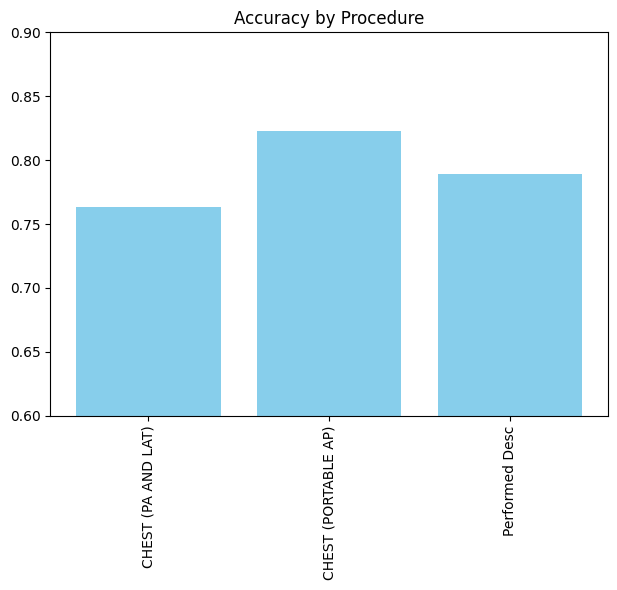

In [11]:

df = test_df

def filter_groups(group):
    return len(group) > 1000 # added higher filter bc quite a lot of other procedures
    
grouped_age_b = df.groupby('PerformedProcedureStepDescription')
mask_procedure = grouped_age_b.apply(filter_groups)
accuracy_age_b = grouped_age_b.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())[mask_procedure]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(accuracy_age_b.index, accuracy_age_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('Accuracy by Procedure')
plt.ylim((0.6,0.9))
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

/tmp/slurm-44332275/ipykernel_150016/2546854112.py:4: RuntimeWarning: invalid value encountered in long_scalars
  fp_b = grouped_age_b.apply(lambda group: (group['TP']).sum()/((group['TP']).sum()+(group['FN']).sum()))[mask_procedure]
/tmp/slurm-44332275/ipykernel_150016/2546854112.py:5: RuntimeWarning: invalid value encountered in long_scalars
  fn_b = grouped_age_b.apply(lambda group: (group['TN']).sum()/((group['TN']).sum()+(group['FP']).sum()))[mask_procedure]


Text(0.5, 1.0, 'TNR (specificity) by Procedure')

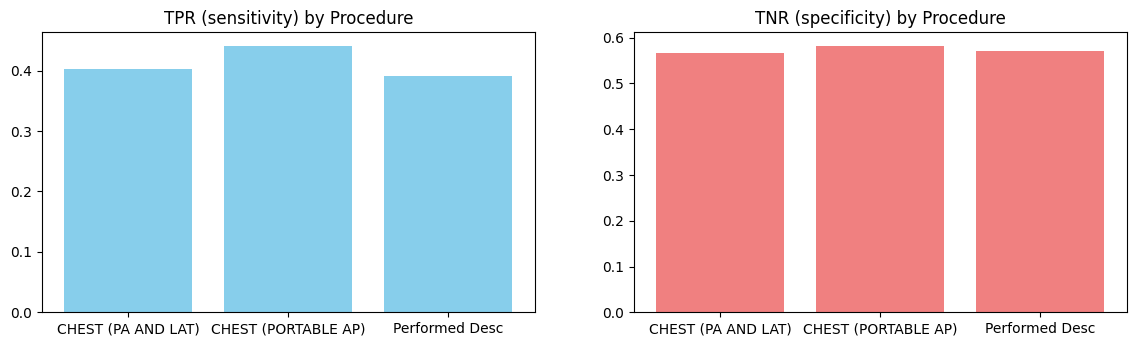

In [47]:
# FN AND FP rates
grouped_age_b = df.groupby('PerformedProcedureStepDescription')
mask_procedure = grouped_age_b.apply(filter_groups)
fp_b = grouped_age_b.apply(lambda group: (group['TP']).sum()/((group['TP']).sum()+(group['FN']).sum()))[mask_procedure]
fn_b = grouped_age_b.apply(lambda group: (group['TN']).sum()/((group['TN']).sum()+(group['FP']).sum()))[mask_procedure]

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.bar(fp_b.index, fp_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('TPR (sensitivity) by Procedure')
#plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
plt.bar(fn_b.index, fn_b, color='lightcoral', capsize=5)
plt.title('TNR (specificity) by Procedure')


Text(0.5, 1.0, 'Proportion of positive labels (ie = no finding) by Procedure')

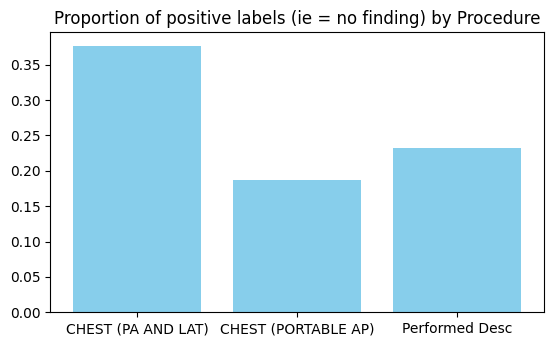

In [43]:
# FN AND FP rates
grouped_age_b = df.groupby('PerformedProcedureStepDescription')
mask_procedure = grouped_age_b.apply(filter_groups)
fp_b = grouped_age_b.apply(lambda group: (group['binary_label']).mean())[mask_procedure]

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.bar(fp_b.index, fp_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('Proportion of positive labels (ie = no finding) by Procedure')
#plt.xticks(rotation=90)


In [44]:
fp_b


PerformedProcedureStepDescription
CHEST (PA AND LAT)     0.377013
CHEST (PORTABLE AP)    0.186822
Performed Desc         0.232658
dtype: float64

In [35]:
accuracy_age_b

PerformedProcedureStepDescription
CHEST (PA AND LAT)     0.763350
CHEST (PORTABLE AP)    0.822845
PORTABLE ABDOMEN       0.743363
Performed Desc         0.788795
dtype: float64

In [31]:
n_groups

PerformedProcedureStepDescription
ABD PORT LINE/TUBE PLACEMENT 1 EXAM                  19
ABD PORT LINE/TUBE PLACEMENT 1 EXAM PORT PORT        36
ABDOMEN (SUPINE AND ERECT)                           25
AP/PA SINGLE VIEW EXPIRATORY CHEST                   33
CHEST (PA AND LAT)                               185962
CHEST (PA AND LAT) PORT                             307
CHEST (PORTABLE AP)                              259439
CHEST (PRE-OP AP ONLY)                                5
CHEST (PRE-OP PA AND LAT)                            15
CHEST (SINGLE VIEW)                                 141
CHEST (SINGLE VIEW) PORT                             67
CHEST PORT LINE/TUBE PLCT 1 EXAM                     29
CHEST PORT. LINE PLACEMENT                           92
DX CHEST 2 VIEW PICC LINE PLACEMENT                 104
DX CHEST PORT LINE/TUBE PLCMT 1 EXAM                 17
DX CHEST PORTABLE PICC LINE PLACEMENT               134
PORTABLE ABDOMEN                                    678
Performed Desc

## AGE 

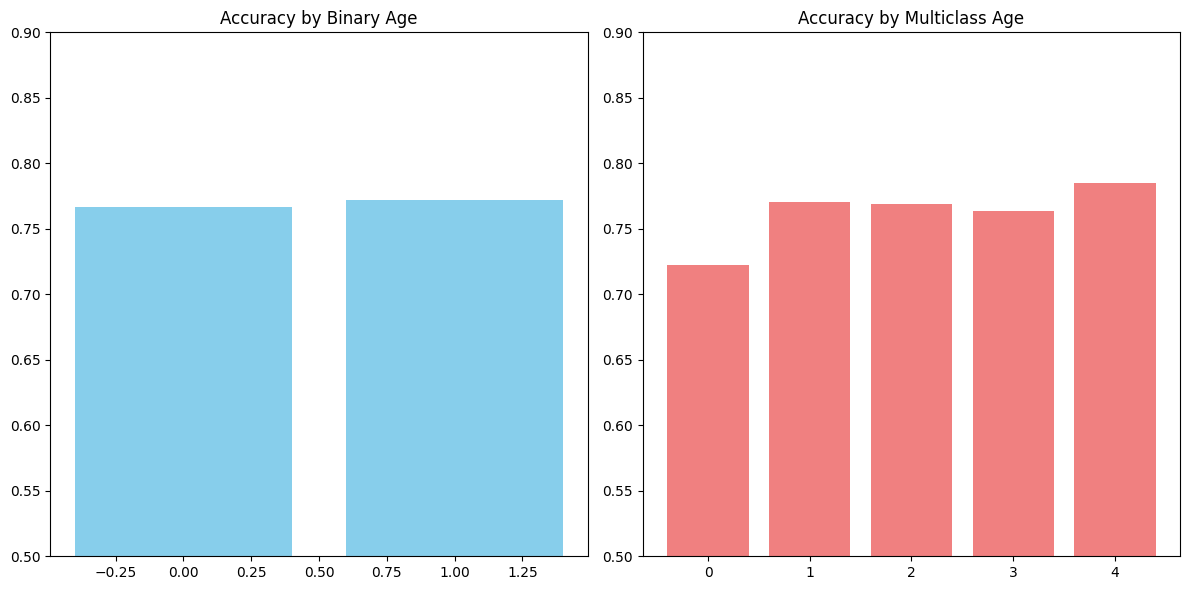

In [125]:
# age:
df = test_df

grouped_age_b = df.groupby('Age_binary')
accuracy_age_b = grouped_age_b.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())

# Group by age and calculate accuracy
grouped_age = df.groupby('Age_multi')
accuracy_age = grouped_age.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(accuracy_age_b.index, accuracy_age_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('Accuracy by Binary Age')
plt.ylim((0.5,0.9))
#plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(accuracy_age.index, accuracy_age, color='lightcoral', capsize=5)
plt.title('Accuracy by Multiclass Age')
plt.ylim((0.5,0.9))

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'N per age group')

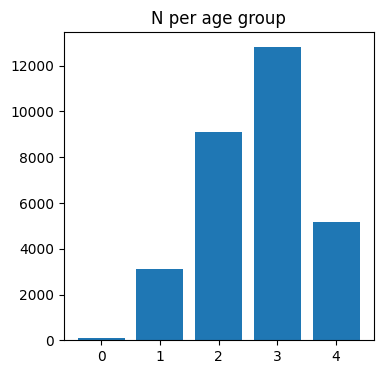

In [70]:
grouped_age = df.groupby('Age_multi')
n_groups = grouped_age.apply(lambda group: len(group))

plt.figure(figsize=(4, 4))
plt.bar(range(len(n_groups)), n_groups, capsize=5)
plt.title('N per age group')


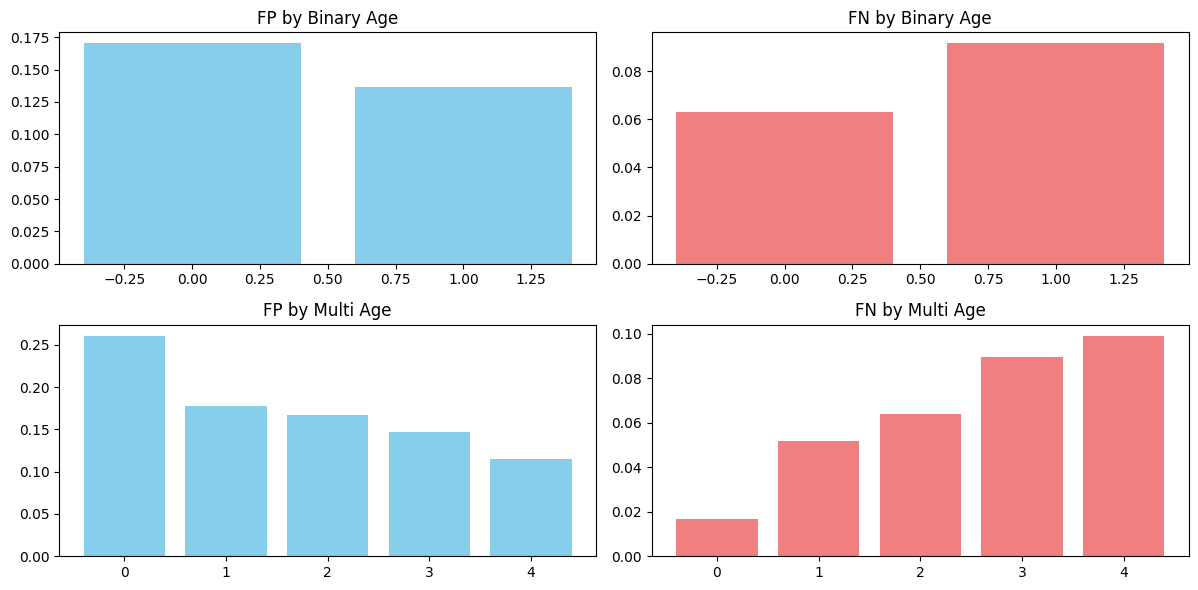

In [73]:
df = test_df

grouped_age_b = df.groupby('Age_binary')
fp_b = grouped_age_b.apply(lambda group: (group['FP']).mean())
fn_b = grouped_age_b.apply(lambda group: (group['FN']).mean())


# Group by age and calculate accuracy
grouped_age_m = df.groupby('Age_multi')
fp_m = grouped_age_m.apply(lambda group: (group['FP']).mean())
fn_m = grouped_age_m.apply(lambda group: (group['FN']).mean())

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.bar(fp_b.index, fp_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('FP by Binary Age')
#plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
plt.bar(fn_b.index, fn_b, color='lightcoral', capsize=5)
plt.title('FN by Binary Age')

plt.subplot(2, 2, 3)
plt.bar(fp_m.index, fp_m, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('FP by Multi Age')
#plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
plt.bar(fn_m.index, fn_m, color='lightcoral', capsize=5)
plt.title('FN by Multi Age')

plt.tight_layout()
plt.show()

## SEX

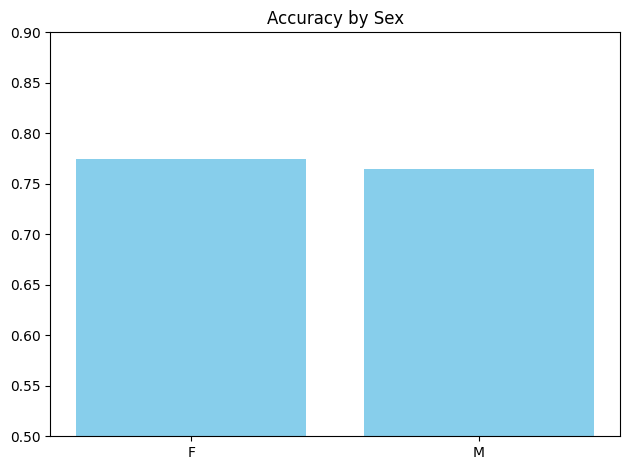

In [76]:
# sex:
df = test_df
    
grouped_age_b = df.groupby('Sex')
accuracy_age_b = grouped_age_b.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())


plt.bar(accuracy_age_b.index, accuracy_age_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('Accuracy by Sex')
plt.ylim((0.5,0.9))
#plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

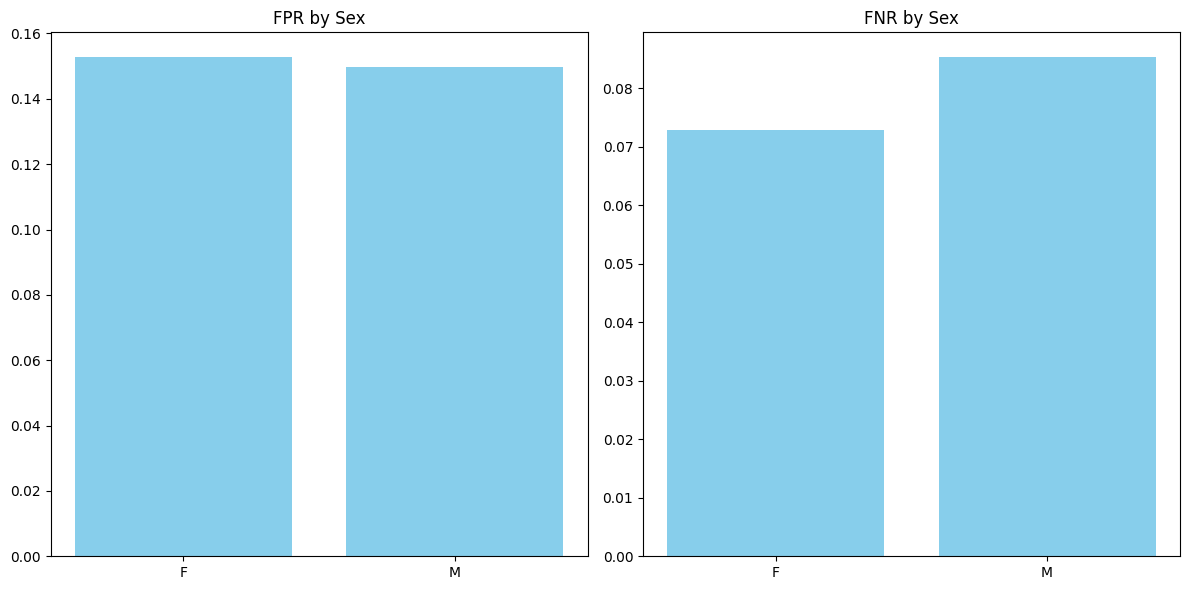

In [77]:
# sex:
df = test_df
    
grouped_age_b = df.groupby('Sex')
accuracy_age_b = grouped_age_b.apply(lambda group: (group['FP']).mean())
fn = grouped_age_b.apply(lambda group: (group['FN']).mean())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(accuracy_age_b.index, accuracy_age_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('FPR by Sex')
#plt.ylim((0.5,0.9))
#plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(accuracy_age_b.index, fn, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('FNR by Sex')

plt.tight_layout()
plt.show()

## ETHNICITY

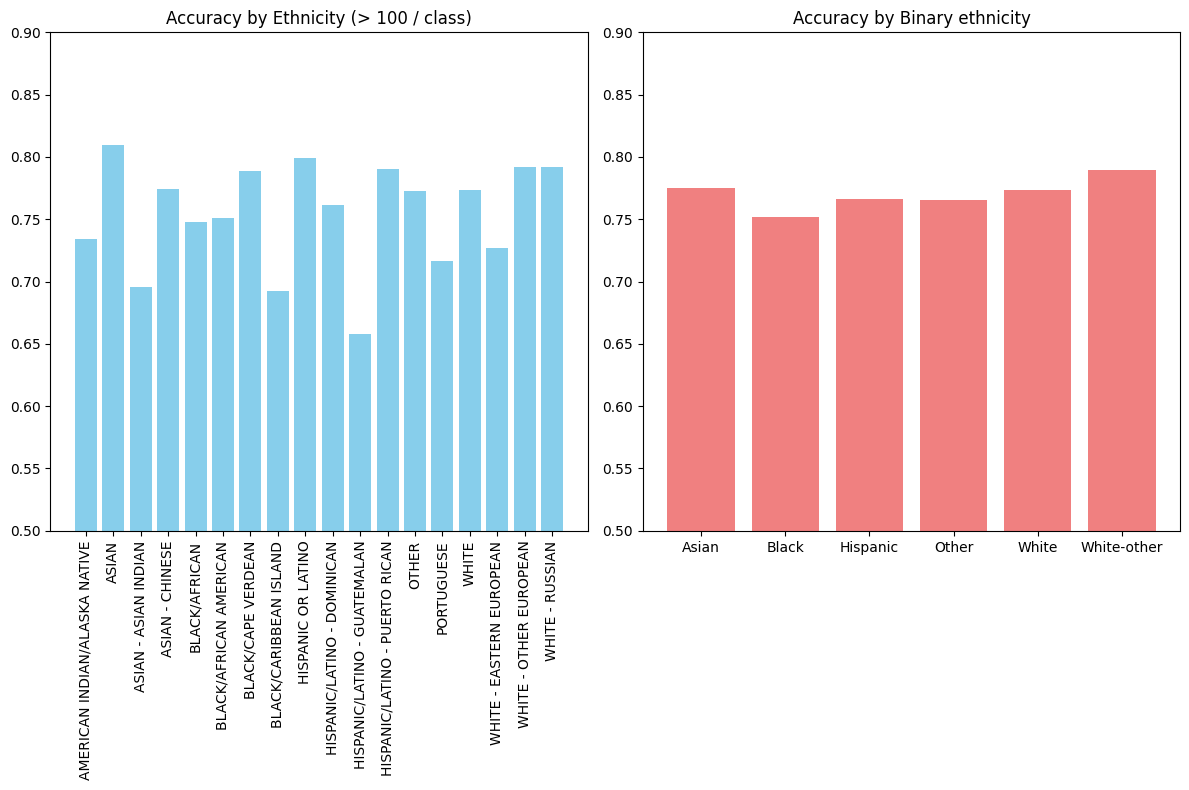

In [39]:
# ethnicity:

df = test_df

def filter_groups(group):
    return len(group) > 100
    
grouped_ethnicity = df.groupby('Race_multi')
mask_ethnicity = grouped_ethnicity.apply(filter_groups)
accuracy_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())[mask_ethnicity]
std_dev_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).std())[mask_ethnicity]

# grouped_ethnicity = df.groupby('Race_multi')
# accuracy_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())
# std_dev_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).std())


# Group by age and calculate accuracy
grouped_age = df.groupby('Race_cat')
accuracy_age = grouped_age.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())
std_dev_age = grouped_age.apply(lambda group: (group['binary_label'] == group['erm_pred']).std())

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.bar(accuracy_ethnicity.index, accuracy_ethnicity, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('Accuracy by Ethnicity (> 100 / class)')

plt.ylim((0.5,0.9))
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(accuracy_age.index, accuracy_age, color='lightcoral', capsize=5)
plt.title('Accuracy by Binary ethnicity')

plt.ylim((0.5,0.9))


plt.tight_layout()
plt.show()

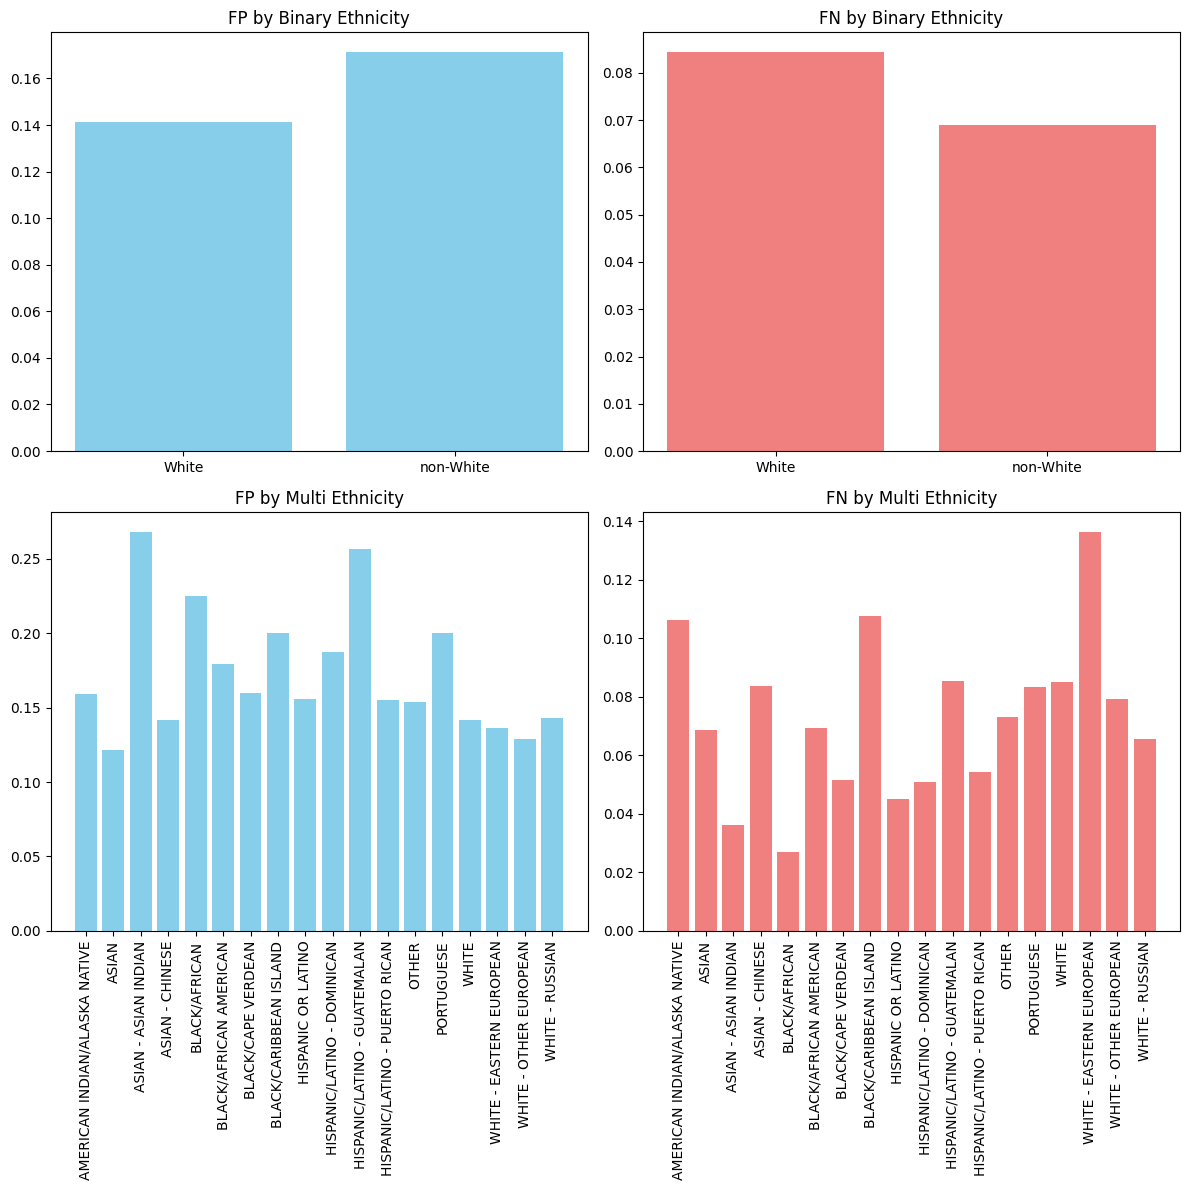

In [41]:
df = test_df

def filter_groups(group):
    return len(group) > 100
    
grouped_ethnicity = df.groupby('Race')
fp_b = grouped_ethnicity.apply(lambda group: (group['FP']).mean())
fn_b = grouped_ethnicity.apply(lambda group: (group['FN']).mean())

grouped_age_m = df.groupby('Race_multi')
mask_ethnicity = grouped_age_m.apply(filter_groups)
fp_m = grouped_age_m.apply(lambda group: (group['FP']).mean())[mask_ethnicity]
fn_m = grouped_age_m.apply(lambda group: (group['FN']).mean())[mask_ethnicity]

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.bar(fp_b.index, fp_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('FP by Binary Ethnicity')
#plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
plt.bar(fn_b.index, fn_b, color='lightcoral', capsize=5)
plt.title('FN by Binary Ethnicity')

plt.subplot(2, 2, 3)
plt.bar(fp_m.index, fp_m, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('FP by Multi Ethnicity')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
plt.bar(fn_m.index, fn_m, color='lightcoral', capsize=5)
plt.title('FN by Multi Ethnicity')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [31]:
test_df['Race_cat'] = test_df['Race_multi'].apply(lambda x: 'White' if x=='WHITE' else 
                                       'White-other' if 'WHITE -' in x else 
                                       'Hispanic' if 'HISPANIC' in x or 'LATINO' in x or 'MEXICAN' in x or 'CENTRAL AMERICAN' in x or 'CUBAN' in x or 'SALVADORAN' in x or 'GUATEMALAN' in x or 'DOMINICAN' in x or 'COLOMBIAN' in x or 'HONDURAN' in x else 
                                       'Asian' if 'ASIAN' in x or 'CHINESE' in x or 'KOREAN' in x or 'SOUTH EAST ASIAN' in x or 'ASIAN INDIAN' in x else 
                                       'Black' if 'BLACK' in x or 'AFRICAN AMERICAN' in x or 'CARIBBEAN ISLAND' in x or 'CAPE VERDEAN' in x else 
                                       'Other')

In [ ]:
def filter_groups(group):
    return len(group) > 100
    
grouped_ethnicity = df.groupby('Race_multi')
mask_ethnicity = grouped_ethnicity.apply(filter_groups)
accuracy_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())[mask_ethnicity]
std_dev_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).std())[mask_ethnicity]

# grouped_ethnicity = df.groupby('Race_multi')
# accuracy_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())
# std_dev_ethnicity = grouped_ethnicity.apply(lambda group: (group['binary_label'] == group['erm_pred']).std())


# Group by age and calculate accuracy
grouped_age = df.groupby('Race')
accuracy_age = grouped_age.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())
std_dev_age = grouped_age.apply(lambda group: (group['binary_label'] == group['erm_pred']).std())


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

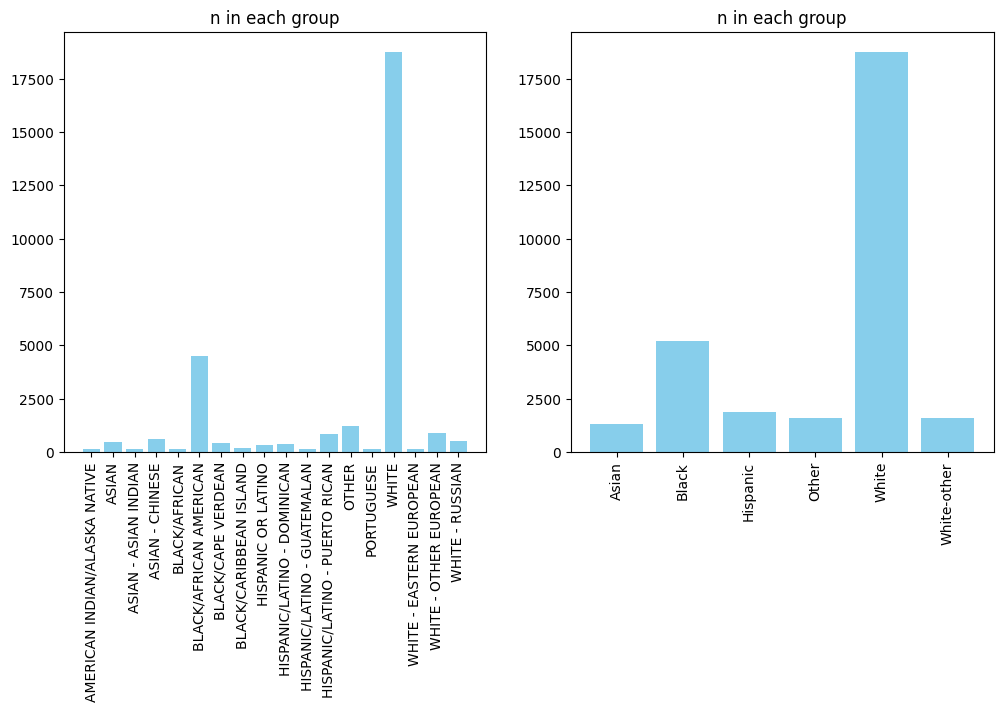

In [35]:
df = test_df

grouped_age_m = df.groupby('Race_multi')
mask_ethnicity = grouped_age_m.apply(filter_groups)
n_df = grouped_age_m.apply(lambda group: len(group))[mask_ethnicity]

grouped_age_c = df.groupby('Race_cat')
mask_ethnicity_c = grouped_age_c.apply(filter_groups)
n_df_c = grouped_age_c.apply(lambda group: len(group))[mask_ethnicity_c]

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.bar(n_df.index, n_df, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('n in each group')
plt.xticks(rotation=90)


plt.subplot(2, 2, 2)
plt.bar(n_df_c.index, n_df_c, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('n in each group')
plt.xticks(rotation=90)



## Intersectional analysis

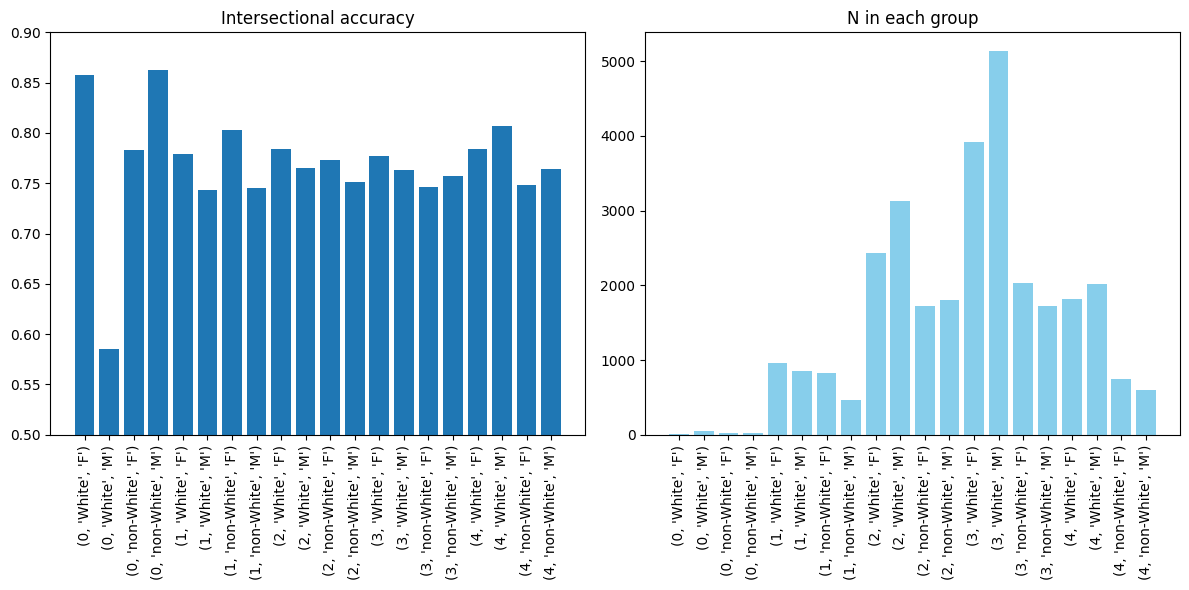

In [72]:
# age:
df = test_df

# Group by all 3
grouped_age = df.groupby(['Age_multi','Race','Sex'])
accuracy_age = grouped_age.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())

# get n for each group

n_groups = grouped_age.apply(lambda group: len(group))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(accuracy_age)), accuracy_age, capsize=5)
plt.title('Intersectional accuracy')
plt.ylim((0.5,0.9))
plt.xticks(range(len(accuracy_age)), accuracy_age.index)
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(range(len(accuracy_age)), n_groups, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('N in each group')
plt.xticks(range(len(accuracy_age)), accuracy_age.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Other tests

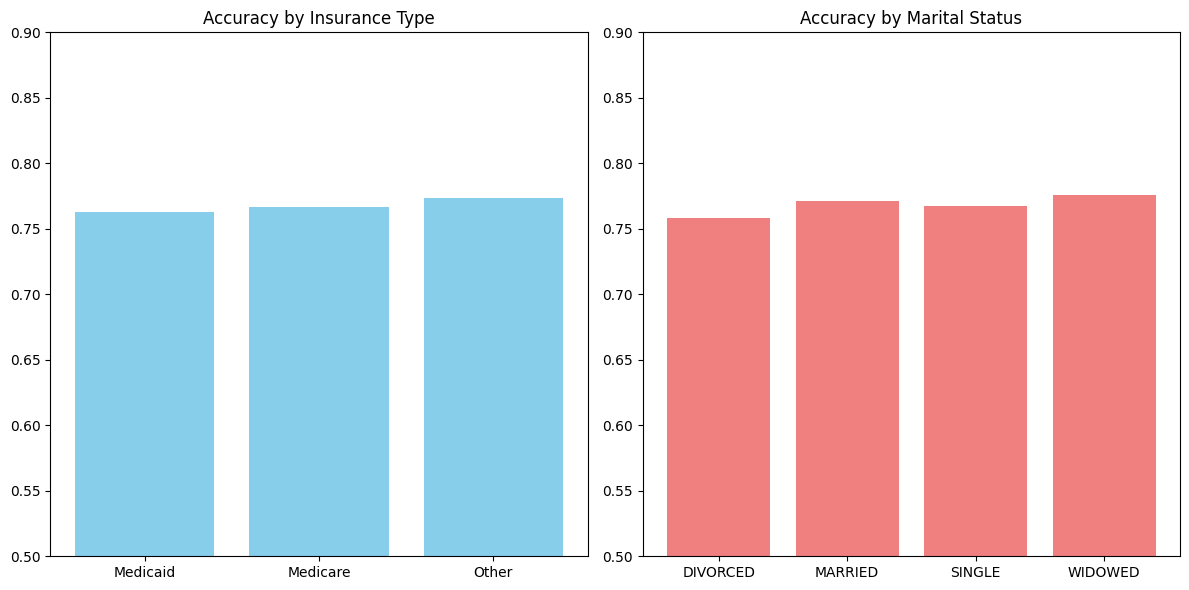

In [75]:
df = test_df

grouped_age_b = df.groupby('insurance')
accuracy_age_b = grouped_age_b.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())

# Group by age and calculate accuracy
grouped_age = df.groupby('marital_status')
accuracy_age = grouped_age.apply(lambda group: (group['binary_label'] == group['erm_pred']).mean())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(accuracy_age_b.index, accuracy_age_b, color='skyblue', capsize=5) # yerr=std_dev_ethnicity
plt.title('Accuracy by Insurance Type')
plt.ylim((0.5,0.9))
#plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(accuracy_age.index, accuracy_age, color='lightcoral', capsize=5)
plt.title('Accuracy by Marital Status')
plt.ylim((0.5,0.9))

plt.tight_layout()
plt.show()

In [95]:
n_df = grouped_ethnicity.apply(lambda group: len(group))
n_df


Race_multi
AMERICAN INDIAN/ALASKA NATIVE                  113
ASIAN                                          452
ASIAN - ASIAN INDIAN                           138
ASIAN - CHINESE                                620
ASIAN - KOREAN                                  24
ASIAN - SOUTH EAST ASIAN                        65
BLACK/AFRICAN                                  111
BLACK/AFRICAN AMERICAN                        4507
BLACK/CAPE VERDEAN                             407
BLACK/CARIBBEAN ISLAND                         195
HISPANIC OR LATINO                             333
HISPANIC/LATINO - CENTRAL AMERICAN              19
HISPANIC/LATINO - COLUMBIAN                     41
HISPANIC/LATINO - CUBAN                         31
HISPANIC/LATINO - DOMINICAN                    373
HISPANIC/LATINO - GUATEMALAN                   117
HISPANIC/LATINO - HONDURAN                      60
HISPANIC/LATINO - MEXICAN                       27
HISPANIC/LATINO - PUERTO RICAN                 830
HISPANIC/LATINO - SA

In [94]:
accuracy_ethnicity

Race_multi
AMERICAN INDIAN/ALASKA NATIVE                0.734513
ASIAN                                        0.829646
ASIAN - ASIAN INDIAN                         0.739130
ASIAN - CHINESE                              0.783871
ASIAN - KOREAN                               0.833333
ASIAN - SOUTH EAST ASIAN                     0.692308
BLACK/AFRICAN                                0.774775
BLACK/AFRICAN AMERICAN                       0.759707
BLACK/CAPE VERDEAN                           0.791155
BLACK/CARIBBEAN ISLAND                       0.702564
HISPANIC OR LATINO                           0.810811
HISPANIC/LATINO - CENTRAL AMERICAN           0.842105
HISPANIC/LATINO - COLUMBIAN                  0.609756
HISPANIC/LATINO - CUBAN                      0.677419
HISPANIC/LATINO - DOMINICAN                  0.785523
HISPANIC/LATINO - GUATEMALAN                 0.658120
HISPANIC/LATINO - HONDURAN                   0.683333
HISPANIC/LATINO - MEXICAN                    0.740741
HISPANIC/LATINO -